<a href="https://www.kaggle.com/code/youneseloiarm/hull-tactical-ensembling-trees-online-training-001?scriptVersionId=282940146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

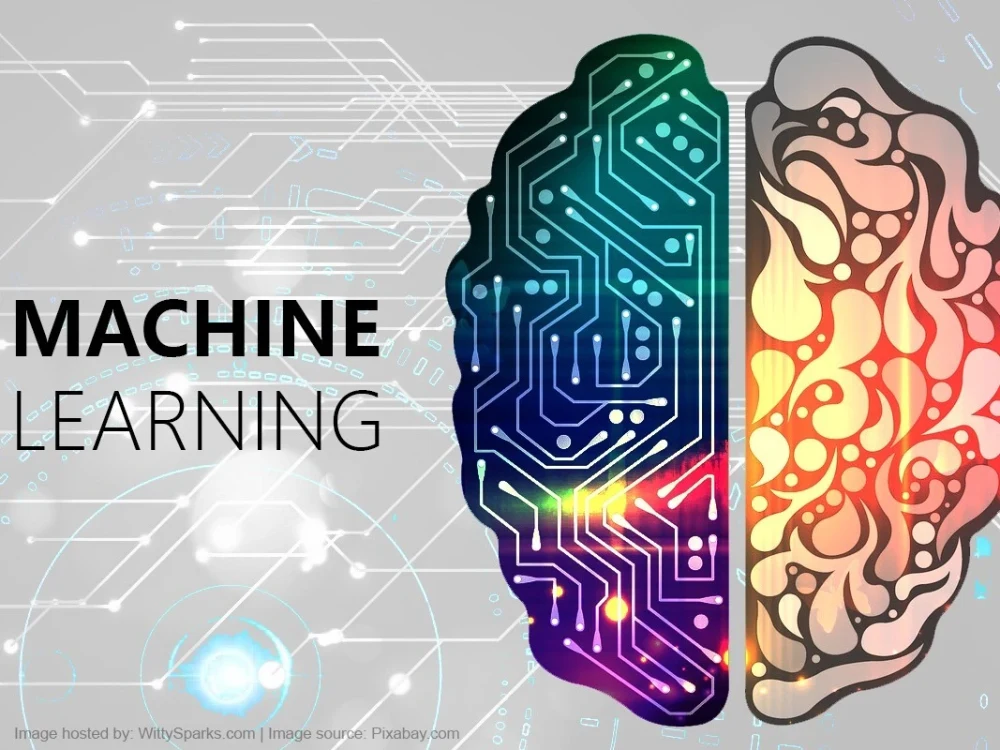

# Introduction:

In this tutorial notebook, you will learn how to use ensemble machine learning models—such as *XGBoost*, *LightGBM*, and *CatBoost*—with an **online training** approach during the API inference submission step.
The good news is that you don’t need to worry about timeouts: online training during submission takes about 27 seconds per row, which means predicting an entire year (252 trading days) takes roughly 2 hours at most. So, don’t be afraid of using online training in this competition.

This notebook is free from any leakage issues, and you can use it as a baseline if you like. If you find it helpful, feel free to encourage me so I can create more tutorials, haha.

Good luck, and enjoy reading!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import kaggle_evaluation.default_inference_server

In [2]:
train = pd.read_csv("/kaggle/input/hull-tactical-market-prediction/train.csv")
train

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,9016,0,0,0,1,0,0,0,0,0,...,0.208995,0.484788,0.717308,0.677249,-0.327455,0.083995,-0.380452,-0.000015,0.000151,-0.000477
9017,9017,0,0,0,1,0,0,0,0,0,...,0.082011,0.482804,1.001028,0.596561,-0.372979,0.094246,-0.427355,-0.005199,0.000150,-0.005661
9018,9018,0,0,0,1,0,-1,0,0,0,...,0.334656,0.486772,0.894502,0.656746,-0.282024,0.090608,-0.381337,0.005930,0.000150,0.005467
9019,9019,0,0,0,1,0,-1,0,0,0,...,0.163360,0.492725,1.117639,0.674603,-0.445261,0.106481,-0.477635,0.008173,0.000150,0.007710


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                            8015 non-null   f

In [4]:
targets = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
features = [ i for i in train.columns if i not in targets]
test_data = train[-180:]
train_data = train[:-180]

In [5]:
target = "forward_returns"
X_train = train_data[features].fillna(0)
y_train = train_data[target]
X_test = test_data[features].fillna(0)
y_test = test_data[target]

In [6]:


def create_models():
    """Create and return the gradient boosting models with the specified parameters."""
    xgb_model = XGBRegressor(
        n_estimators=2000,       # more boosting rounds
        max_depth=7,            # deeper trees
        learning_rate=0.01,      # smaller LR for stability
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        random_state=42,
        tree_method="hist",
        device="cuda"            # remove if no GPU
    )
    
    lgbm_model = LGBMRegressor(
        n_estimators=2000,
        max_depth=7,
        learning_rate=0.01,
        num_leaves=256,          # more leaves for depth
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=1,
        random_state=42,
        device="gpu",           # remove if no GPU
        verbose=-1
    )

    catboost_model = CatBoostRegressor(
        iterations=2000,
        depth=7,
        learning_rate=0.01,
        l2_leaf_reg=3,
        random_seed=42,
        loss_function='RMSE',
        task_type="GPU",         # remove if no GPU
        verbose=False
    )
    
    return [xgb_model, lgbm_model, catboost_model]

def train_with_validation(models, X_train, y_train, validation_split=0.25):
    """
    Train models with validation on the last portion of training data.
    
    Parameters:
    -----------
    models : list
        List of model objects to train
    X_train : array-like
        Training features
    y_train : array-like
        Training targets
    validation_split : float, default=0.25
        Proportion of training data to use for validation (last 25% by default)
    
    Returns:
    --------
    tuple: (trained_models, validation_metrics)
    """
    warnings.filterwarnings("ignore")
    
    # Calculate split point for validation
    n_samples = len(X_train)
    split_idx = int(n_samples * (1 - validation_split))
    
    # Split training data into training and validation sets
    X_train_split = X_train[:split_idx]
    y_train_split = y_train[:split_idx]
    X_val = X_train[split_idx:]
    y_val = y_train[split_idx:]
    
    print(f"Training samples: {len(X_train_split)}, Validation samples: {len(X_val)}")
    
    trained_models = []
    validation_metrics = {}
    
    model_names = ['XGBoost', 'LightGBM', 'CatBoost']
    
    for i, model in enumerate(models):
        model_name = model_names[i]
        print(f"\nTraining {model_name}...")
        
        # Train the model
        if model_name == 'CatBoost':
            model.fit(X_train_split, y_train_split, 
                     eval_set=(X_val, y_val),
                     verbose=False)
        elif model_name == 'LightGBM':
            model.fit(X_train_split, y_train_split, 
                     eval_set=(X_val, y_val))#,
                     #verbose=False)
        else:
            model.fit(X_train_split, y_train_split,
                     eval_set=[(X_val, y_val)],
                     verbose=False)
        
        # Make predictions on validation set
        y_pred = model.predict(X_val)
        
        # Calculate validation metrics
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        
        validation_metrics[model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae
        }
        
        print(f"{model_name} Validation Metrics:")
        print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        trained_models.append(model)
    
    return trained_models, validation_metrics

def online_training_pipeline(X_train, y_train, validation_split=0.25):
    """
    Complete pipeline for creating and training models with validation.
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training targets
    validation_split : float, default=0.25
        Proportion of training data to use for validation
    
    Returns:
    --------
    tuple: (trained_models, validation_metrics)
    """
    print("Creating models...")
    models = create_models()
    
    print(f"Starting training with validation on last {validation_split*100}% of data...")
    trained_models, validation_metrics = train_with_validation(
        models, X_train, y_train, validation_split
    )
    
    print(f"\nTraining completed. {len(trained_models)} models trained and validated.")
    return trained_models, validation_metrics

# Example usage:
if __name__ == "__main__":
    # Assuming you have X_train and y_train defined
    trained_models, metrics = online_training_pipeline(X_train, y_train,validation_split = 0.0025)
    
    # Or with custom validation split
    # trained_models, metrics = online_training_pipeline(X_train, y_train, validation_split=0.3)
    pass

Creating models...
Starting training with validation on last 0.25% of data...
Training samples: 8818, Validation samples: 23

Training XGBoost...
XGBoost Validation Metrics:
  MSE: 0.0001, RMSE: 0.0080, MAE: 0.0066

Training LightGBM...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


LightGBM Validation Metrics:
  MSE: 0.0001, RMSE: 0.0081, MAE: 0.0068

Training CatBoost...
CatBoost Validation Metrics:
  MSE: 0.0001, RMSE: 0.0082, MAE: 0.0068

Training completed. 3 models trained and validated.




### 📌 Clarification About `validation_split` in Online Training

When working with **online training / incremental learning**, the idea is to train the model on historical data but validate only on **recent observations**.
However, many users mistakenly set something like:

```python
validation_split = 0.25
```

If you have **9000 days** of data, `0.25` means:

* **2250 days** (≈ 9 years) of data become the validation set.

This makes **no sense** for online training, because online models should not be validated on extremely old historical behavior.

---

#### 📊 Why Large Validation Splits Are Wrong in Online Training

Online training focuses on **recent market regimes**, not the past decade.
So validation should be restricted to a **small recent window** (e.g., last 30, 22, or 9 days).

Below is a clarification table.

---

#### 📊 Recommended `validation_split` for Online Training (9000 days dataset)

| Desired Validation Window | Days | Fraction of 9000 days | Suggested `validation_split` |
| ------------------------- | ---- | --------------------- | ---------------------------- |
| **30 days**               | 30   | 30 / 9000 ≈ 0.0033    | `validation_split ≈ 0.003`   |
| **22 days**               | 22   | 22 / 9000 ≈ 0.00244   | `validation_split < 0.0025`  |
| **9 days**                | 9    | 9 / 9000 ≈ 0.001      | `validation_split ≈ 0.001`   |
| **1 day**                 | 1    | 1 / 9000 ≈ 0.00011    | `validation_split ≈ 0.0001`  |

---

#### ✅ Key Takeaway

If you use online training, your validation period **must be recent and very small**.
Using a large validation split forces the model to validate on years of old data, which does not represent the **current market regime**.

So instead of `0.25`, use something between:

```
0.0001  → 0.003
```

depending on how many recent days you want to validate on.



In [7]:
def ensemble_predict(models, X):
    """
    Predict using a list of trained models and return the averaged prediction.
    
    Parameters:
        models : list of trained models
        X      : numpy array or DataFrame of features
        
    Returns:
        ensemble_pred : averaged prediction across models
    """
    preds = [model.predict(X) for model in models]
    ensemble_pred = np.mean(preds, axis=0)
    return ensemble_pred

In [8]:
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2


class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """
    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ZeroDivisionError
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()

    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)


In [9]:
preds = ensemble_predict(trained_models, X_test)

In [10]:
### Simulation:
solution = train[["date_id","forward_returns","risk_free_rate"]][-180:]
submission = pd.DataFrame()
submission = train[["date_id"]][-180:]
submission["prediction"] = preds
submission.columns = ["date_id","prediction"]
# Turn negatives into 0, keep positives as they are
submission["prediction"] = submission["prediction"].apply(lambda x: x*2 if x > 0 else 0)#0.0009)

# Run scoring
score_value = score(solution, submission, row_id_column_name="date_id")
print("Adjusted Sharpe Score:", score_value)

Adjusted Sharpe Score: -0.033170066503910946


In [11]:
allocation = 1.0 + 50 * preds
allocation = np.clip(allocation, 0.0, 2.0)
# Turn negatives into 0, keep positives as they are
submission["prediction"] = allocation

# Run scoring
score_value = score(solution, submission, row_id_column_name="date_id")
print("Adjusted Sharpe Score:", score_value)

Adjusted Sharpe Score: 0.5673452947556995


In [12]:
def create_lagged_features(dataframe):
    """Add lagged target variables to the dataset."""
    target_columns = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    dataframe["is_scored"] = False

    for target_col in target_columns:
        dataframe[f"lagged_{target_col}"] = dataframe[target_col].shift(1)

    return dataframe

In [13]:
train = create_lagged_features(train)

In [14]:
import time
count = 0
online_X_train = None
online_y_train = None

def predict(test_df: "pl.DataFrame") -> float:
    global features, train, count, online_X_train, online_y_train
    
    start_time = time.time()  # ⏱️ Start timing
    test_df = test_df.to_pandas()
    Date_id = test_df["date_id"].unique()[0]
    if count == 0:
        # Initialize training set up to the current date
        train_df = train.loc[train["date_id"] < Date_id]
        X_train, y_train = train_df[features].fillna(0), train_df[target].fillna(0)
        
        # Example usage: training all models
        trained_models, metrics = online_training_pipeline(X_train, y_train,validation_split = 0.0025)
        
        # Initialize online training data
        online_X_train = pd.concat([train_df[features], test_df[features]], ignore_index=True).fillna(0)
        online_y_train = pd.concat(
            [train_df["lagged_forward_returns"], test_df["lagged_forward_returns"]],
            ignore_index=True
        ).fillna(0)
        
    else:
        # Incremental (pseudo-online) learning step
        X_train, y_train = online_X_train.shift(1).fillna(0), online_y_train
        # Example usage: training all models
        trained_models, metrics = online_training_pipeline(X_train, y_train,validation_split = 0.0025)
        # Append latest batch
        online_X_train = pd.concat([online_X_train, test_df[features]], ignore_index=True).fillna(0)
        online_y_train = pd.concat([online_y_train, test_df["lagged_forward_returns"]], ignore_index=True).fillna(0)
    


    # Predict on the current test batch
    X_test = test_df[features]
    preds = ensemble_predict(trained_models, X_test)[0]

    # Apply leverage allocation
    allocation = 1.0 + 50 * preds
    allocation = np.clip(allocation, 0.0, 2.0)
    
    # ⏱️ Measure elapsed time
    elapsed_time = time.time() - start_time
    print(f"Step {count} (FULL PROCESSING - last is_scored=True): {elapsed_time:.4f} seconds")
    print("="*25)
    count += 1
    return float(allocation)

In [15]:
import os
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if __name__ == "__main__":
    if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
        inference_server.serve()
    else:
        inference_server.run_local_gateway(("/kaggle/input/hull-tactical-market-prediction/",))

Creating models...
Starting training with validation on last 0.25% of data...
Training samples: 8957, Validation samples: 23

Training XGBoost...
XGBoost Validation Metrics:
  MSE: 0.0001, RMSE: 0.0071, MAE: 0.0053

Training LightGBM...
LightGBM Validation Metrics:
  MSE: 0.0001, RMSE: 0.0071, MAE: 0.0053

Training CatBoost...
CatBoost Validation Metrics:
  MSE: 0.0000, RMSE: 0.0070, MAE: 0.0054

Training completed. 3 models trained and validated.
Step 0 (FULL PROCESSING - last is_scored=True): 38.7178 seconds
Creating models...
Starting training with validation on last 0.25% of data...
Training samples: 8958, Validation samples: 23

Training XGBoost...
XGBoost Validation Metrics:
  MSE: 0.0001, RMSE: 0.0071, MAE: 0.0054

Training LightGBM...
LightGBM Validation Metrics:
  MSE: 0.0001, RMSE: 0.0071, MAE: 0.0053

Training CatBoost...
CatBoost Validation Metrics:
  MSE: 0.0000, RMSE: 0.0070, MAE: 0.0053

Training completed. 3 models trained and validated.
Step 1 (FULL PROCESSING - last i

# Conclusion

**Online training** is no longer a secret—it’s a straightforward and accessible technique. You can use this tutorial as inspiration to build your own customized online-training notebook for the competition.



Good luck, and thank you for reading!